# Object Detection on brain tumor dataset with active ML - demo

## Imports & Installs

In [1]:
# Check you have access to a GPU
!nvidia-smi

Thu Oct 26 14:25:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from IPython.display import clear_output

In [3]:
!pip install ultralytics && pip install pyyaml && pip install roboflow
clear_output()
# restart runtime

In [4]:
from roboflow import Roboflow
import glob
import os
import matplotlib.pyplot as plt
import yaml
import os


## Import the dataset from Roboflow

In [5]:
rf = Roboflow(api_key="your_key")
project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
dataset = project.version(2).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.201, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to brain-tumor-2 in yolov8:: 100%|██████████| 19812/19812 [00:04<00:00, 4784.57it/s]


## Fixing the data.yaml file to work properly in colab and organize the data for our active ML demo.
We assume here that the original training set is our unlabeled set of images, the validation set is our testing data, and the test set is our labeled data because it has the fewest examples.


In [6]:
def rename_folders(current_folder_name, new_folder_name):
  # Check if the folder exists
  if os.path.exists(current_folder_name):
      # Rename the folder
      os.rename(current_folder_name, new_folder_name)
  else:
      print(f'The folder {current_folder_name} does not exist.')

rename_folders(current_folder_name='/content/brain-tumor-2/train', new_folder_name='/content/brain-tumor-2/unlabeled')
rename_folders(current_folder_name='/content/brain-tumor-2/valid', new_folder_name='/content/brain-tumor-2/testing')
rename_folders(current_folder_name='/content/brain-tumor-2/test', new_folder_name='/content/brain-tumor-2/labeled')

In [7]:
path_data_yaml = '/content/brain-tumor-2/data.yaml'

with open(path_data_yaml, 'r') as file:
    data = yaml.safe_load(file)
data['train'] = 'labeled/images'
data['val'] = ''
data['test'] = 'testing/images'
with open(path_data_yaml, 'w') as file:
    yaml.dump(data, file)

In [8]:
unlabeled_files = glob.glob('/content/brain-tumor-2/unlabeled/images/*.jpg')
labeled_files = glob.glob('/content/brain-tumor-2/labeled/images/*.jpg')
testing_files = glob.glob('/content/brain-tumor-2/testing/images/*.jpg')

print(f"For our demo, we have {len(unlabeled_files)} unlabeled files, {len(labeled_files)} labeled files, and {len(testing_files)} testing files")

For our demo, we have 6930 unlabeled files, 990 labeled files, and 1980 testing files


## Training

In [9]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

print('Start training ')
results = model.train(data=path_data_yaml,
                      batch=32,
                      task='detect',
                      mode='train',
                      epochs=10
                      )


100%|██████████| 21.5M/21.5M [00:00<00:00, 152MB/s] 


Start training 


Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/brain-tumor-2/data.yaml, epochs=10, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False

## Evaluation

In [10]:
metrics = model.val(data=path_data_yaml, split='test')

Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/brain-tumor-2/testing/labels.cache... 1980 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]
                   all       1980       4442      0.602      0.476      0.495      0.225
                label0       1980       1268      0.664      0.319      0.401      0.156
                label1       1980       1963      0.624      0.689      0.687      0.363
                label2       1980       1211      0.519      0.421      0.398      0.157
Speed: 0.3ms preprocess, 10.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2


In [11]:
metrics.results_dict

{'metrics/precision(B)': 0.6022637781613859,
 'metrics/recall(B)': 0.4763619681952341,
 'metrics/mAP50(B)': 0.4953616848732552,
 'metrics/mAP50-95(B)': 0.2252478418006819,
 'fitness': 0.25225922610793927}

## Active Learning loop

In [12]:
# Run the model on each image in the unlabeled set
results = model(os.path.join('/content/brain-tumor-2/', 'unlabeled/images'), verbose=False, conf=0.15)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



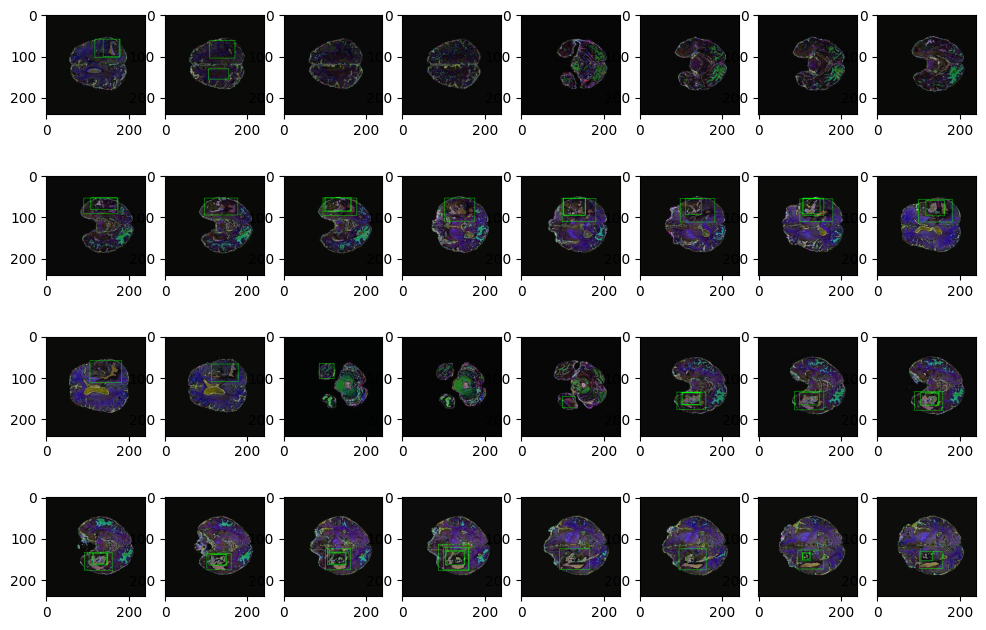

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

confidences = []

plt.figure(figsize=(12, 8))
for i in range(1, 33):
  plt.subplot(4,8,i)
  image = results[i].orig_img
  for b in results[i].boxes.xywhn:
    x, y, w, h = b.tolist()
    # Convert YOLO format coordinates to OpenCV format coordinates
    dh, dw, _ = image.shape
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    cv2.rectangle(image, (l, t), (r, b), (0, 255, 0), 1)
  confidences.append(results[i].boxes.conf)

  plt.imshow(image)

plt.show()

In [14]:
confidences = []
for result in results:
  confidences.append(result.boxes.conf)

In [15]:
len(confidences)

6930

In [19]:
confidence_scores = []
for confidence in confidences:
  if len(confidence) > 0:
    confidence_scores.append(np.min(np.array(confidence.cpu())))
  else:
    confidence_scores.append(10)

In [20]:
len(confidence_scores)

6930

In [21]:
import torch
# Number of queries we want to select from the unlabeled set
num_queries = 500

# Sort by uncertainty
sorted_uncertainties, indices = torch.sort(torch.tensor(confidence_scores))

# Get original indices of most uncertain samples
most_uncertain_indices = indices[-num_queries:]

print(f"sorted_uncertainties: {sorted_uncertainties[0:num_queries]} \nmost_uncertain_indices selected: {most_uncertain_indices}\n")

sorted_uncertainties: tensor([0.1500, 0.1500, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1502, 0.1502, 0.1502, 0.1502, 0.1502, 0.1502, 0.1502, 0.1502, 0.1502, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1504, 0.1504, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1505, 0.1506, 0.1506, 0.1506, 0.1506,
        0.1506, 0.1506, 0.1506, 0.1507, 0.1507, 0.1507, 0.1507, 0.1507, 0.1508, 0.1508, 0.1508, 0.1508, 0.1508, 0.1508, 0.1508, 0.1508, 0.1508, 0.1509, 0.1509, 0.1509, 0.1509, 0.1510, 0.1510, 0.1510, 0.1510, 0.1510, 0.1510, 0.1510, 0.1510, 0.1511, 0.1511, 0.1511, 0.1511, 0.1511, 0.1512, 0.1512, 0.1512, 0.1512, 0.1512,
        0.1513, 0.1513, 0.1513, 0.1513, 0.1513, 0.1513, 0.1514, 0.1514, 0.1514, 0.1514, 0.1514, 0.1514, 0.1514, 0.1514, 0.1515, 0.1515, 0.1515, 0.1515, 0.1515, 0.1515, 0.1515, 0.1515, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1517, 0.1517, 0.1517, 0.1517, 0.1517, 0.1517, 0.1518, 0.1518, 0.1518,
        0.1518, 0.

### Select the images

In [22]:
images_selected = np.array(glob.glob(os.path.join('/content/brain-tumor-2/', 'unlabeled/images', '*.jpg')))[np.array(most_uncertain_indices)]

In [23]:
len(images_selected)

500

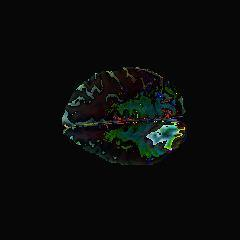

In [24]:
from PIL import Image
Image.open(images_selected[0])

In [25]:
images_labeled = glob.glob('/content/brain-tumor-2/labeled/images/*.jpg')
len(images_labeled)

990

In [26]:
labels_labeled = glob.glob('/content/brain-tumor-2/labeled/labels/*.txt')
len(labels_labeled)

990

In [27]:
import shutil

for image_path in images_selected:
  shutil.move(image_path, image_path.replace('unlabeled', 'labeled'))
  label_file = image_path.replace('images', 'labels').replace('.jpg', '.txt')
  shutil.move(label_file, label_file.replace('unlabeled', 'labeled'))

In [28]:
images_labeled = glob.glob('/content/brain-tumor-2/labeled/images/*.jpg')
len(images_labeled)

1490

In [29]:
labels_labeled = glob.glob('/content/brain-tumor-2/labeled/labels/*.txt')
len(labels_labeled)

1490

### Train again

In [30]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

print('Start training ')
results = model.train(data=path_data_yaml,
                      batch=32,
                      task='detect',
                      mode='train',
                      epochs=10
                      # pretrained=args.pretrained,
                      )


Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/brain-tumor-2/data.yaml, epochs=10, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=Fals

Start training 


  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1838080  ultralytics.nn.modules.block.C2f             [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

In [31]:
metrics = model.val(data=path_data_yaml, split='test')
metrics.results_dict

Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/brain-tumor-2/testing/labels.cache... 1980 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]
                   all       1980       4442      0.647      0.511      0.544      0.267
                label0       1980       1268      0.658      0.351      0.422      0.173
                label1       1980       1963      0.673      0.711      0.716      0.401
                label2       1980       1211       0.61       0.47      0.493      0.225
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train32


{'metrics/precision(B)': 0.6469528069030884,
 'metrics/recall(B)': 0.5106541285546612,
 'metrics/mAP50(B)': 0.543579045283473,
 'metrics/mAP50-95(B)': 0.26662268193511757,
 'fitness': 0.29431831826995314}